### Install following packages

- yfinance
- tensorflow
- keras

If they don't show up, add conda-forge in the channel.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from keras import backend as K

import tensorflow as tf


2024-12-13 20:19:05.186811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 20:19:05.202439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 20:19:05.206805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 20:19:05.218997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


[*********************100%***********************]  1 of 1 completed


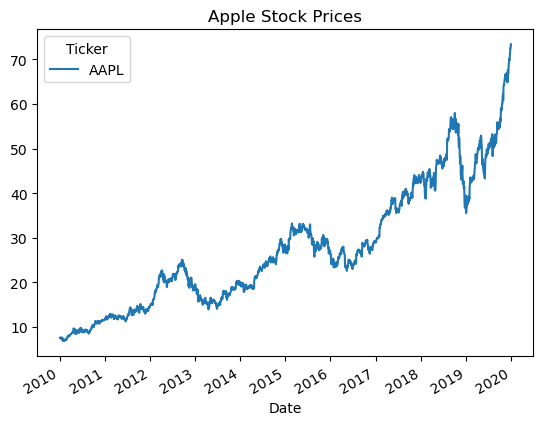

In [3]:
# Download stock data for Apple from Yahoo Finance for the specified date range.
data = yf.download('AAPL', start='2010-01-01', end='2020-01-01')
data = data[['Close']]  # We will predict the closing price
data['Close'].plot(title='Apple Stock Prices')
plt.show()

In [4]:
data.values.size

2516

In [5]:
# Normalize the data
# Normalize the data to a range of 0 to 1 for better performance of neural networks.

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)


# Function to create datasets for training and testing.
# This function segments the data into features (X) and target (Y) with a specified number of time steps.
# Create data in 60 timesteps and convert into array

def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

X, y = create_dataset(scaled_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Reshape input to be [samples, time steps, features] which is required for LSTM models.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [6]:
# Build the LSTM model,
# Building the LSTM model with two LSTM layers and two Dense layers.

# Initializes a linear stack of layers in the model. In a Sequential model, each layer has exact one input tensor and one output tensor.
model = Sequential()

# This line adds a Long Short-Term Memory (LSTM) layer with 50 units (neurons).
model.add(
    LSTM(50, return_sequences=True, input_shape=(60, 1))
)  # First LSTM layer with 50 units, returns sequences for stacking LSTM layers.

# TODO add two additional LSTM layers
model.add(
    LSTM(50, return_sequences=True, input_shape=(60, 1))
)

model.add(
    LSTM(50, return_sequences=True, input_shape=(60, 1))
)

# Unlike the first LSTM layer, this parameter setting tells the layer to output only the last step of the sequence.
# This is useful when the next layer is a dense layer that expects a single vector input rather than a sequence.
model.add(
    LSTM(50, return_sequences=False)
)  # Second LSTM layer, does not return sequences to flatten output for the dense layer.

# TODO add Dropout layers
model.add(Dropout(0.1))
# TODO add Dense layer with ReLU as activation function
model.add(Dense(50, activation="relu"))

# This adds a fully connected (dense) layer with 25 neurons.
# Dense layers are standard neural network layers where each input is connected to each output by a learnable weight.
# This layer will interpret the features learned by the LSTM layers, effectively beginning the process of converting the learned sequences into a final prediction.
model.add(Dense(25))  # Dense layer with 25 neurons.

# The final layer in the model is another dense layer, but with just one neuron.
# This is the output layer, and its purpose is to produce a single continuous output value that predicts the next day's closing price.
model.add(Dense(1))  # Output layer with 1 neuron to predict the closing price.

# Compile the model,
# TODO change to two different optimizers other than Adam
# Compile the model using Adam optimizer and mean squared error as the loss function.
learn_rate = 0.001
# optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
optimizer = tf.keras.optimizers.Lion(learning_rate=learn_rate)
# optimizer = tf.keras.optimizers.Adafactor(learning_rate=learn_rate)

model.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", "mean_squared_error", rmse],
)

# Train the model
num_epochs = 10
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=num_epochs,
    batch_size=64,
    verbose=1,
)

# Predicting and inverse transformation to original prices
# Predicting and transforming predictions back to original scale.
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

I0000 00:00:1734139158.717942  218733 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734139162.650695  218733 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734139162.650814  218733 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734139162.654235  218733 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734139162.654343  218733 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/10


2024-12-13 20:19:32.478254: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0533 - mean_absolute_error: 0.1683 - mean_squared_error: 0.0533 - rmse: 0.3011 - val_loss: 0.0031 - val_mean_absolute_error: 0.0492 - val_mean_squared_error: 0.0031 - val_rmse: 0.2903
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0062 - mean_absolute_error: 0.0615 - mean_squared_error: 0.0062 - rmse: 0.2891 - val_loss: 0.0024 - val_mean_absolute_error: 0.0364 - val_mean_squared_error: 0.0024 - val_rmse: 0.2694
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0022 - mean_absolute_error: 0.0381 - mean_squared_error: 0.0022 - rmse: 0.2858 - val_loss: 0.0020 - val_mean_absolute_error: 0.0390 - val_mean_squared_error: 0.0020 - val_rmse: 0.2727
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0025 - mean_absolute_error: 0.0418 - mean_squared_error: 0.0025 - rmse: 0.2889 - val_loss: 0.0019 - val_mean_absolute_error: 0.0402 - val_mean_squared_error: 0.0019 - val_rmse: 0.2862
Epoch 5/10
31/31 ━━━━━━━━━━━━━━

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,704 (584.79 KB)

 Trainable params: 74,851 (292.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 74,853 (292.40 KB)

In [8]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'rmse', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'val_rmse'])

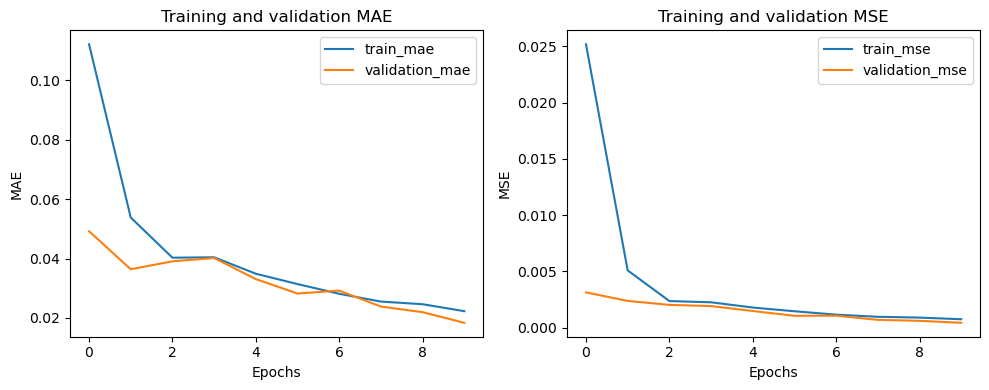

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot training & validation MAE values
ax1.plot(
    range(num_epochs), history.history["mean_absolute_error"], label="train_mae"
)
ax1.plot(
    range(num_epochs),
    history.history["val_mean_absolute_error"],
    label="validation_mae",
)
ax1.set_title("Training and validation MAE")
ax1.set_ylabel("MAE")
ax1.set_xlabel("Epochs")
ax1.legend()

# Plot training & validation MSE values
ax2.plot(
    range(num_epochs), history.history["mean_squared_error"], label="train_mse"
)
ax2.plot(
    range(num_epochs),
    history.history["val_mean_squared_error"],
    label="validation_mse",
)
ax2.set_title("Training and validation MSE")
ax2.set_ylabel("MSE")
ax2.set_xlabel("Epochs")
ax2.legend()

fig.tight_layout()
plt.show()

In [10]:
fig.savefig(f"numEpochs_{num_epochs}-learningRate_{learn_rate}.png")